## Access SOOP Tropical Research Vessel Realtime QC data in Parquet

A jupyter notebook to show how to access and plot SOOP TRV data available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/8af21108-c535-43bf-8dab-c1f45a26088c).

In [1]:
dataset_name = "vessel_trv_realtime_qc"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 234 packages in 34ms


In [3]:
import requests
import os
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [4]:
from DataQuery import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, \
    get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import pandas as pd
import pyarrow.compute as pc
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

platform_code: string
timestamp: int32
polygon: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'platform_code')
print(list(unique_partition_value)[0:2])  # showing a subset only

['VMQ9273', 'VNCF']
CPU times: user 17.3 ms, sys: 1.31 ms, total: 18.6 ms
Wall time: 18 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:486: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:486: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


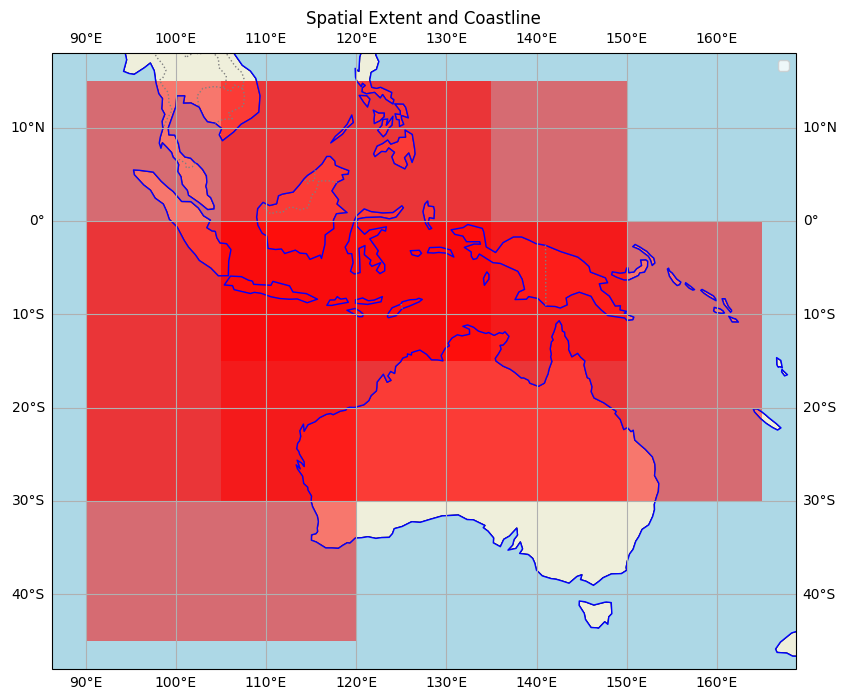

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

In [9]:
get_temporal_extent(parquet_ds)

(Timestamp('2008-09-30 00:27:27'), Timestamp('2022-10-09 20:55:57'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'platform_code': {'type': 'string'},
 'timestamp': {'type': 'int64'},
 'polygon': {'type': 'string'},
 'filename': {'type': 'string'},
 'LATITUDE_quality_control': {'type': 'double',
  'long_name': 'LATITUDE quality control',
  'standard_name': 'latitude status_flag',
  'quality_control_conventions': 'IMOS standard set using the IODE flags',
  'valid_min': 0.0,
  'valid_max': 9.0,
  'flag_values': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0],
  'flag_meanings': 'no_qc_performed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed not_used not_used interpolated_values missing_values'},
 'LATITUDE': {'type': 'double',
  'long_name': 'latitude',
  'standard_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'reference_datum': 'geographical coordinates, WGS84 projection',
  'ancillary_variables': 'LATITUDE_quality_control'},
 'LONGITUDE_quality_control': {'type': 'double',
  'long_name':

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2010-01-01 10:14:00', date_end='2010-03-01 07:50:00')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-23, lat_max=-20, lon_min=150, lon_max=155)


filter = filter_geo & filter_time

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800906 entries, 0 to 800905
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   filename                   800906 non-null  object        
 1   LATITUDE_quality_control   800906 non-null  float64       
 2   LATITUDE                   800906 non-null  float64       
 3   LONGITUDE_quality_control  800906 non-null  float64       
 4   LONGITUDE                  800906 non-null  float64       
 5   DEPTH                      800906 non-null  float64       
 6   CPHL                       211652 non-null  float64       
 7   CPHL_quality_control       211652 non-null  float64       
 8   TIME                       800906 non-null  datetime64[ns]
 9   TURB                       210179 non-null  float32       
 10  TURB_quality_control       210179 non-null  float32       
 11  TEMP                       212770 non-null  float32 

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

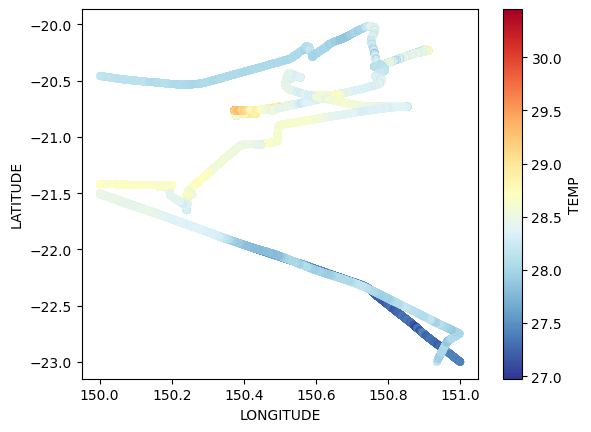

In [13]:
df.plot.scatter(x="LONGITUDE", y='LATITUDE', c="TEMP", cmap='RdYlBu_r')

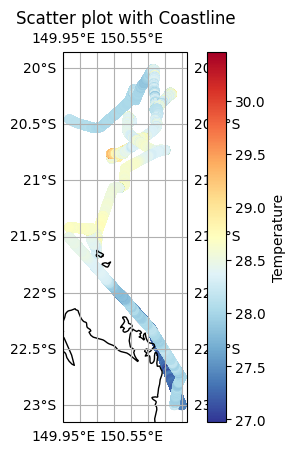

In [14]:
import cartopy.crs as ccrs
from matplotlib.colors import Normalize

norm = Normalize(vmin=df['TEMP'].min(), vmax=df['TEMP'].max())

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df["TEMP"], cmap='RdYlBu_r', norm=norm, transform=ccrs.PlateCarree())

# Add a coastline
ax.coastlines()

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Temperature')

ax.gridlines(draw_labels=True)
ax.set_title('Scatter plot with Coastline')
plt.show()

## Create a TIME and scalar/number filter

In [15]:
filter_time = create_time_filter(parquet_ds, date_start='2010-01-31 10:14:00', date_end='2010-02-01 07:50:00')

expr_1 = pc.field('platform_code') == pa.scalar("VNCF")
filter = expr_1 & filter_time

In [16]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11038 entries, 0 to 11037
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   filename                   11038 non-null  object        
 1   LATITUDE_quality_control   11038 non-null  float64       
 2   LATITUDE                   11038 non-null  float64       
 3   LONGITUDE_quality_control  11038 non-null  float64       
 4   LONGITUDE                  11038 non-null  float64       
 5   DEPTH                      11038 non-null  float64       
 6   CPHL                       3931 non-null   float64       
 7   CPHL_quality_control       3931 non-null   float64       
 8   TIME                       11038 non-null  datetime64[ns]
 9   TURB                       3091 non-null   float32       
 10  TURB_quality_control       3091 non-null   float32       
 11  TEMP                       3953 non-null   float32       
 12  TEMP

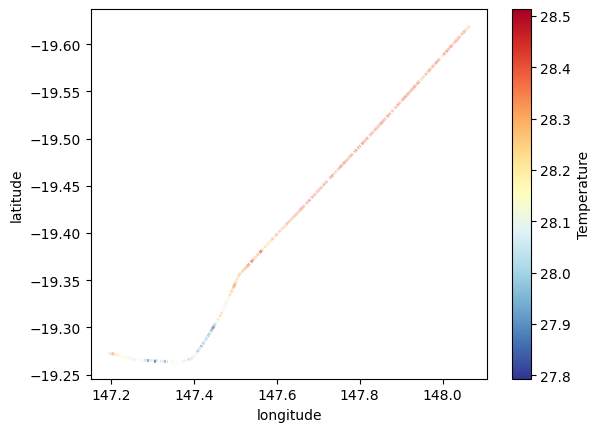

In [17]:
df_sorted = df.sort_values('TIME')

# Create a list of segments
points = np.array([df_sorted['LONGITUDE'], df_sorted['LATITUDE']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection with segments colored by temperature
norm = plt.Normalize(df_sorted['TEMP'].min(), df_sorted['TEMP'].max())
lc = LineCollection(segments, cmap='RdYlBu_r', norm=norm)
lc.set_array(df_sorted['TEMP'])
lc.set_linewidth(2)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.set_xlabel(metadata['LONGITUDE']['standard_name'])
ax.set_ylabel(metadata['LATITUDE']['standard_name'])
ax.invert_yaxis()

# Adding color bar
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Temperature')

plt.show()